In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import requests
import tqdm as tqdm
import json
import os
import sys
import gc


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Import custom functions
sys.path.append('/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/functions')
import functions as f

# Define the path to the data
path = '/content/drive/My Drive/Colab Notebooks/final project/audio/'

NameError: name 'drive' is not defined

In [ ]:
# Define the spectrogram to RGB conversion function
def spectrogram_to_rgb(spectrogram, eps=1e-6):
    # Min-max scale to fit inside 8-bit RGB
    img = 255 * (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + eps)
    # Convert to uint8
    img = img.astype(np.uint8)

    # Stack the image to create a 3-channel image
    img = np.stack([img] * 3, axis=-1)
    return img

# Load resnet18 model with pretrained weights
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),  # 512 for resnet18 or 2048 for resnet 50
        nn.ReLU(inplace=True),
        nn.Dropout(.2),
        nn.Linear(128, 6),
        nn.Sigmoid()
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    return model, optimizer

def loss_fn(y_pred, y_true):
    return torch.sum(torch.abs(y_pred - y_true)) / y_pred.shape[0]

In [ ]:
def load_checkpoint(model, optimizer, filename='/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/audio_nn_model_sonic_first.pth'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
model, optimizer = get_model()

model, optimizer, start_epoch, losslogger = load_checkpoint(model, optimizer)
model = model.to(device)
# now individually transfer the optimizer parts...
for state in optimizer.state.values():
  for k, v in state.items():
    if isinstance(v, torch.Tensor):
      state[k] = v.to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 245MB/s]


=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/audio_nn_model_sonic_first.pth'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/audio_nn_model_sonic_first.pth' (epoch 13)


In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch.onnx

In [ ]:
# Create a dummy input tensor with the shape (batch_size, channels, height, width)
dummy_input = torch.randn(16, 3, 125, 1025)

dummy_input.to(device)
# Set the model to evaluation mode
model.eval()
model.to(device)

# Run the model on the dummy input tensor
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(dummy_input)

# output is now of type <class 'torch.Tensor'>
print(type(output))  # Should print: <class 'torch.Tensor'>
print(output.shape)  # Print the shape of the output tensor

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Create a new training set, with 1000 samples of each class
N_instruments = 1300
X1, y1 = f.generate_mixed_spectrograms(N_instruments, 1, path=path)
X2, y2 = f.generate_mixed_spectrograms(N_instruments, 2, path=path)
X3, y3 = f.generate_mixed_spectrograms(N_instruments, 3, path=path)
X4, y4 = f.generate_mixed_spectrograms(N_instruments, 4, path=path)
X5, y5 = f.generate_mixed_spectrograms(N_instruments, 5, path=path)
X6, y6 = f.generate_mixed_spectrograms(N_instruments, 6, path=path)

# Add the data to a single test array
X_train_multi = np.concatenate((X1, X2, X3, X4, X5, X6))
y_train_multi = np.concatenate((y1, y2, y3, y4, y5, y6))

# Shuffle the data using numpy
shuffled_indices = np.random.permutation(len(y_train_multi))
mixed_spectograms = X_train_multi[shuffled_indices]
labels = y_train_multi[shuffled_indices]
gc.collect()


100%|██████████| 1300/1300 [00:25<00:00, 50.79it/s]


1680

In [ ]:
# Convert spectrograms to RGB
X_rgb = np.array([spectrogram_to_rgb(s) for s in mixed_spectograms])

# Split into training, validation, and test sets (80/10/10)
X_train, X_val, X_test, y_train, y_val, y_test = f.split_data(X_rgb, labels, 0.1, 0.1)
gc.collect()
# Convert numpy arrays to torch tensors and permute dimensions
X_train_rgb = torch.tensor(X_train).permute(0, 3, 1, 2).float()
gc.collect()
y_train = torch.tensor(y_train).float()
gc.collect()
X_val_rgb = torch.tensor(X_val).permute(0, 3, 1, 2).float()
gc.collect()
y_val = torch.tensor(y_val).float()
gc.collect()
X_test_rgb = torch.tensor(X_test).permute(0, 3, 1, 2).float()
gc.collect()
y_test = torch.tensor(y_test).float()
gc.collect()
# Scale the data to be between 0 and 1
def torch_min_max_normalization(X):
    X = (X - X.min()) / (X.max() - X.min())
    return X

X_train_rgb = torch_min_max_normalization(X_train_rgb)
X_val_rgb = torch_min_max_normalization(X_val_rgb)
X_test_rgb = torch_min_max_normalization(X_test_rgb)

# Create data loaders
batch_size = 16
train_dataset = TensorDataset(X_train_rgb, y_train)
val_dataset = TensorDataset(X_val_rgb, y_val)
test_dataset = TensorDataset(X_test_rgb, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

gc.collect()

0

In [ ]:
gc.collect()
# Function to calculate accuracy
def get_accuracy(y_pred, y_true):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred == y_true)
    return accuracy

epoch_val_loss = 0
epoch_val_acc = 0
with torch.no_grad():
  for x_batch, y_batch in val_loader:
      y_pred = model(x_batch.to(device))
      loss = loss_fn(y_pred, y_batch.to(device))
      epoch_val_loss += loss.item()
      epoch_val_acc += get_accuracy(y_pred, y_batch)

epoch_val_acc/len(val_loader), epoch_val_loss/len(val_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


(0.9478458049886622, 0.3300037740596703)

In [ ]:
# Function to train the model
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=100, patience=5):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                y_pred = model(x_batch.to(device))
                loss = loss_fn(y_pred, y_batch.to(device))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += loss.item()
            epoch_train_acc += get_accuracy(y_pred, y_batch)

        train_loss.append(epoch_train_loss / len(train_loader))
        train_acc.append(epoch_train_acc / len(train_loader))

        model.eval()
        epoch_val_loss = 0
        epoch_val_acc = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred = model(x_batch.to(device))
                loss = loss_fn(y_pred, y_batch.to(device))
                epoch_val_loss += loss.item()
                epoch_val_acc += get_accuracy(y_pred, y_batch)

        val_loss.append(epoch_val_loss / len(val_loader))
        val_acc.append(epoch_val_acc / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]}, Train Acc: {train_acc[-1]}, Val Loss: {val_loss[-1]}, Val Acc: {val_acc[-1]}")

        if epoch > patience and val_loss[-1] > min(val_loss[-patience:]):
            print("Early stopping due to no improvement in validation loss.")
            break

    return model, train_loss, train_acc, val_loss, val_acc

# Train the model
trained_model, train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=100, patience=10)

Epoch 1/100, Train Loss: 0.30523318546131634, Train Acc: 0.9513087606837609, Val Loss: 0.3271008123244558, Val Acc: 0.9480583900226758
Epoch 2/100, Train Loss: 0.22833756308716077, Train Acc: 0.9642628205128206, Val Loss: 0.25108907911546374, Val Acc: 0.9596797052154196
Epoch 3/100, Train Loss: 0.19683223387751825, Train Acc: 0.969444444444445, Val Loss: 0.25154562811462244, Val Acc: 0.9584750566893423
Epoch 4/100, Train Loss: 0.17348176824549835, Train Acc: 0.9724626068376069, Val Loss: 0.24160527848467536, Val Acc: 0.9603174603174605
Epoch 5/100, Train Loss: 0.1481162179643527, Train Acc: 0.9771901709401715, Val Loss: 0.24552547004149886, Val Acc: 0.9598214285714286
Epoch 6/100, Train Loss: 0.12940622178407815, Train Acc: 0.9803151709401705, Val Loss: 0.24722371615317404, Val Acc: 0.960955215419501
Epoch 7/100, Train Loss: 0.12184322052277051, Train Acc: 0.9814102564102571, Val Loss: 0.2671407563041668, Val Acc: 0.9557823129251701
Epoch 8/100, Train Loss: 0.11931293476850559, Train A

In [ ]:
trained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
losslogger = [train_loss, val_loss]
epoch      = len(train_loss)

state = {'epoch': epoch + 1, 'state_dict': trained_model.state_dict(),
             'optimizer': optimizer.state_dict(), 'losslogger': losslogger}

torch.save(state, '/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/audio_nn_model_sonic.pth')

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/'
model_file = 'audio_nn_model.pth'

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Create the full path
model_path = os.path.join(model_dir, model_file)

# Save the model state dictionary
torch.save(model.state_dict(), model_path)

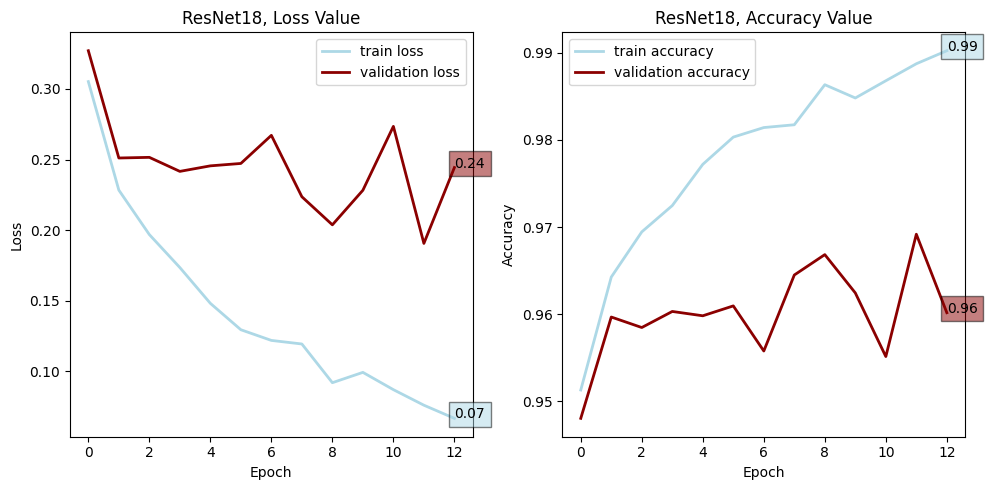

In [ ]:

final_train_loss = train_loss[-1]
final_train_acc = train_acc[-1]
final_val_loss = val_loss[-1]
final_val_acc = val_acc[-1]

# Plotting with customization
plt.figure(figsize=(10, 5))

# Plot the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train loss', color='lightblue', linewidth=2)
plt.plot(val_loss, label='validation loss', color='darkred', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18, Loss Value')
plt.legend()

# Annotate final values
plt.text(len(train_loss)-1, final_train_loss, f'{final_train_loss:.2f}', bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(len(val_loss)-1, final_val_loss, f'{final_val_loss:.2f}', bbox=dict(facecolor='darkred', alpha=0.5))

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train accuracy', color='lightblue', linewidth=2)
plt.plot(val_acc, label='validation accuracy', color='darkred', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18, Accuracy Value')
plt.legend()

# Annotate final values
plt.text(len(train_acc)-1, final_train_acc, f'{final_train_acc:.2f}', bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(len(val_acc)-1, final_val_acc, f'{final_val_acc:.2f}', bbox=dict(facecolor='darkred', alpha=0.5))

plt.tight_layout()
plt.savefig("ResNet18_Loss_and_acc_plots(TrainvsVal)")
plt.show()

In [ ]:

losslogger = [train_loss, val_loss] epoke = len(train_loss) tilstand = {'epoch': epoke + 1, 'state_dict': trained_model.state_dict(), 'optimizer': optimizer.state_dict(), 'losslogger': losslogger} torch.save(state, '/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/audio_nn_model_sonic.pth')

In [ ]:
# Make predictions with the validation DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all predictions and labels into single arrays
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Print the shape of the predictions and labels
print("Predictions shape:", all_predictions.shape)
print("Labels shape:", all_labels.shape)


# Convert predictions to binary (0 or 1) if they are probabilities
all_predictions = np.round(all_predictions)

# Ensure all_labels are binary
all_labels = np.round(all_labels)

Predictions shape: (780, 6)
Labels shape: (780, 6)


Accuracy for organ: 0.9936
Accuracy for bass: 0.9449
Accuracy for guitar: 0.9205
Accuracy for vocal: 0.9962
Accuracy for flutes: 0.9885
Accuracy for keyboards: 0.9179
Accuracy for files with 1 instruments: 1.0000
Accuracy for files with 2 instruments: 0.9922
Accuracy for files with 3 instruments: 0.9605
Accuracy for files with 4 instruments: 0.9343
Accuracy for files with 5 instruments: 0.9356
Accuracy for files with 6 instruments: 0.9536


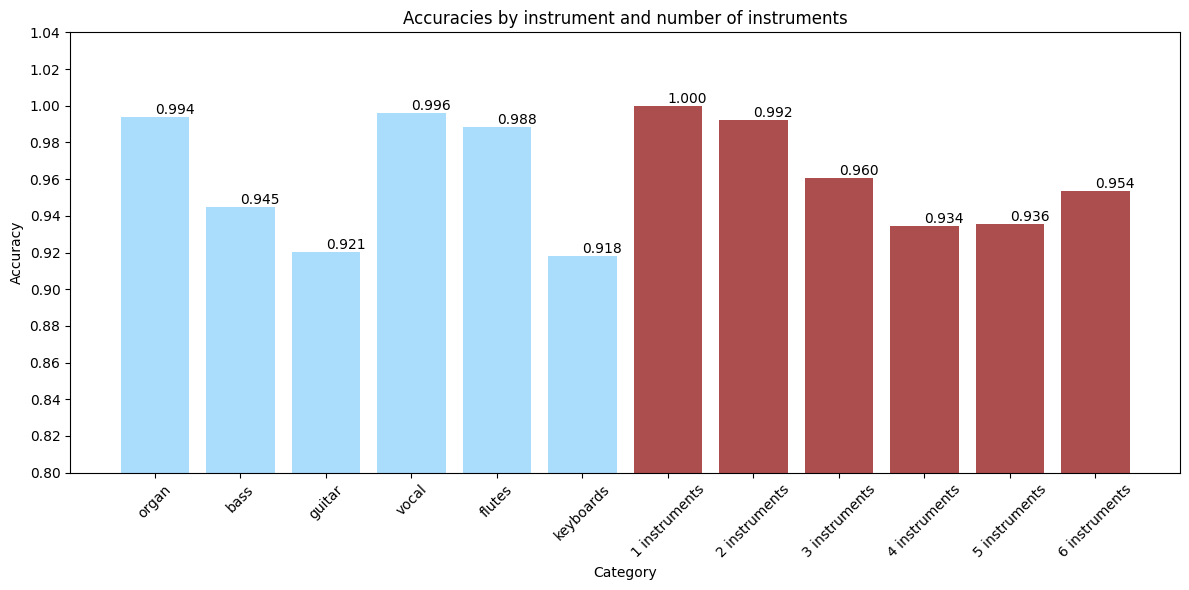

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Class names
instruments = ["organ", "bass", "guitar", "vocal", "flutes", "keyboards"]

# Initialize a dictionary to store the accuracy for each class
accuracies_instrument = {}

num_instruments = np.sum(all_labels, axis=1)

# Calculate accuracy for each class
for i, instrument in enumerate(instruments):
    correct_predictions = (all_predictions[:, i] == all_labels[:, i])
    accuracies_instrument[instrument] = correct_predictions.mean()

# Print the accuracy for each class
for instrument, accuracy in accuracies_instrument.items():
    print(f"Accuracy for {instrument}: {accuracy:.4f}")

# Assuming unique_instruments and num_instruments are defined
unique_instruments = np.unique(num_instruments)

accuracies_num = {}
for num in unique_instruments:
    indices = np.where(num_instruments == num)
    y_pred_subset = all_predictions[indices]
    y_true_subset = all_labels[indices]

    accuracy = (y_pred_subset == y_true_subset).mean()  # Simple accuracy calculation
    accuracies_num[num] = accuracy

# Print the accuracy for each category
for num, accuracy in accuracies_num.items():
    print(f"Accuracy for files with {int(num)} instruments: {accuracy:.4f}")

# Combine data for histogram
labels = list(accuracies_instrument.keys()) + [f"{int(num)} instruments" for num in unique_instruments]
accuracies = list(accuracies_instrument.values()) + list(accuracies_num.values())

# Define colors
colors = ['#87CEFA'] * len(accuracies_instrument) + ['#8A0303'] * len(accuracies_num)

# Plotting the histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, accuracies, alpha=0.7, color=colors)
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.title('Accuracies by instrument and number of instruments')
plt.xticks(rotation=45)

# Set y-axis limits and add extra ticks
plt.ylim(0.8, 1)
plt.yticks(np.arange(0.8, 1.05, 0.02))

# Adding value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', va='bottom')  # va: vertical alignment

plt.tight_layout()
plt.savefig("Accuracies_by_instrument_and number_of_instruments")
plt.show()




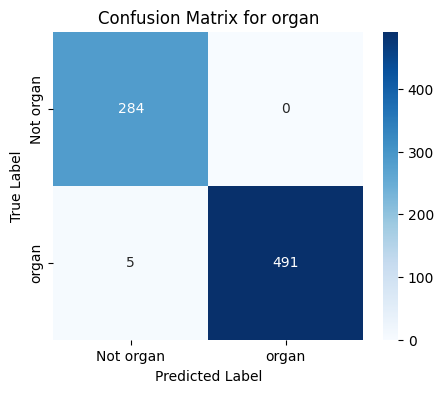

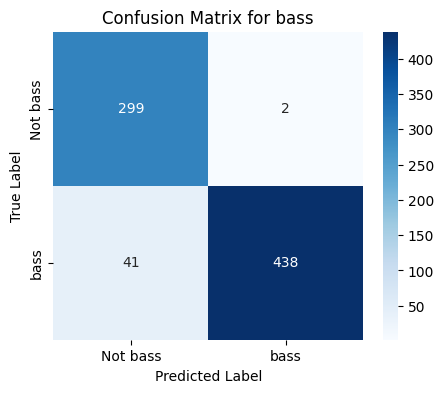

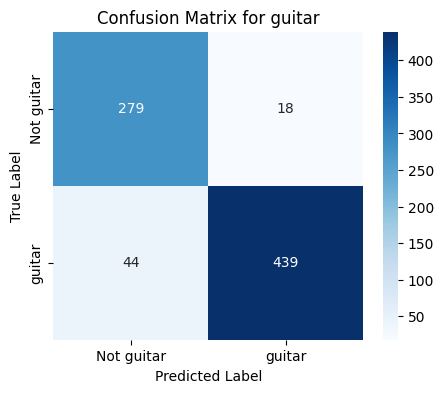

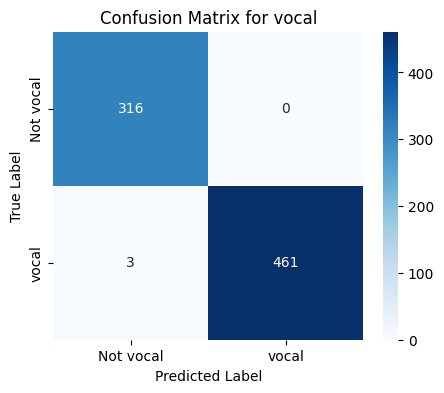

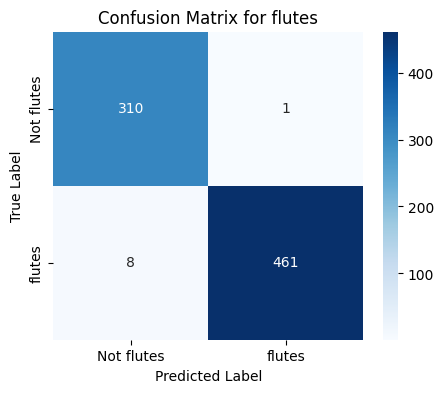

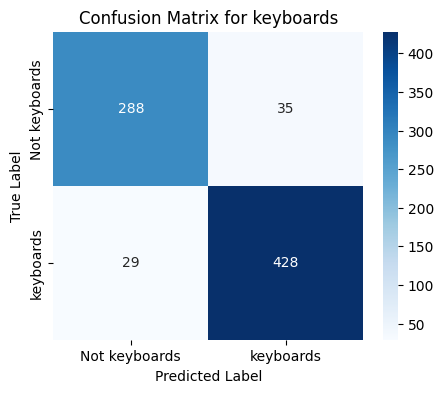

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


all_predictions = np.round(all_predictions)

# Ensure all_labels are binary
all_labels = np.round(all_labels)

# Class names
instruments = ["organ", "bass", "guitar", "vocal", "flutes", "keyboards"]

# Calculate and plot confusion matrix for each class
for i, instrument in enumerate(instruments):
    # Calculate confusion matrix for the current class
    cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Not {instrument}', instrument], yticklabels=[f'Not {instrument}', instrument])
    plt.title(f'Confusion Matrix for {instrument}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f"Confusion_matrix_for_{instrument}")
    plt.show()


